# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

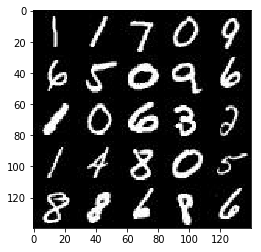

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

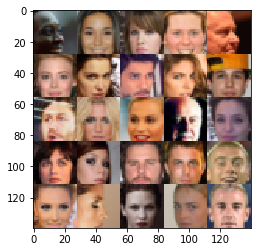

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [80]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_images')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_images, z_input, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [109]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # Hyperparameter to control leaky ReLU for the discriminator
    ALPHA_D = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #Layer 1
        # Input layer is 28x28x(number of colour channels)
        # No batch normalization in the first layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        lrelu1 = tf.maximum(ALPHA_D * conv1, conv1)
        #14x14x64 now
        
        # Layer 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(ALPHA_D * bn2, bn2)
        #7x7x128 now
        
        # Layer 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(ALPHA_D * bn3, bn3)
        #4x4x256 now

        # Layer 4
        # Get logits and sigmoid output
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [112]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Hyperparameter to control leaky ReLU for generator
    ALPHA_G = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Flatten
        flat = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(flat, training=is_train)
        relu1 = tf.maximum(ALPHA_G * bn1, bn1)
        # 7x7x512 now
        
        # Layer 2
        # Convolution transpose.
        convt2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(convt2, training=is_train)
        relu2 = tf.maximum(ALPHA_G * convt2, convt2)
        # 14x14x256 now
        
        # Layer 3
        # Convolution transpose.
        convt3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(convt3, training=is_train)
        relu3 = tf.maximum(ALPHA_G * convt3, convt3)
        # 28x28x256 now
        
        # Layer 4
        # Output layer, 28x28xout_channel_dim. 
        # Use stride 1 to add an extra layer to model and maintain width and height.
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now (stride of 1 used)
        
        out = tf.tanh(logits)
        
    return (out)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Notes on the Architecture
Both Discriminator and Generator have 4 layers.
The model seems to work best when the alpha values for the Discriminator and Generator are close but not equal. Possibly this introduces a little extra noise into the model which helps start the learning process.

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [83]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # Label smoothing hyperparameter
    SMOOTH = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - SMOOTH)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_fake, labels=tf.zeros_like(d_logits_real) * (1 - SMOOTH)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_fake, labels=tf.ones_like(d_logits_fake) * (1 - SMOOTH)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [97]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [98]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [99]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    PRINT_EVERY = 10 #Steps between print of training data
    SHOW_EVERY = 100 #Steps between drawing of generator output
    
    input_real, input_z, lr_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_ph, beta1)
    
    # Count steps to decide when to print out latest progress statistics
    steps = 0
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale batch image data up from range -0.5, 0.5 to range -1, 1
                batch_images = batch_images * 2

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr_ph: learning_rate})

                # Print data about training progress
                if steps % PRINT_EVERY == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, step {}...".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save loss data to plot later.
                    losses.append((train_loss_d, train_loss_g))
                
                # Generate sample images
                if steps % SHOW_EVERY == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
    
    # Plot a graph of the Generator and Discriminator loss to determine how well they are working.
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, step 10... Discriminator Loss: 1.3850... Generator Loss: 16.6710
Epoch 1/2, step 20... Discriminator Loss: 0.4157... Generator Loss: 6.9019
Epoch 1/2, step 30... Discriminator Loss: 3.6920... Generator Loss: 0.7535
Epoch 1/2, step 40... Discriminator Loss: 1.3419... Generator Loss: 2.9613
Epoch 1/2, step 50... Discriminator Loss: 1.4660... Generator Loss: 3.3738
Epoch 1/2, step 60... Discriminator Loss: 1.0287... Generator Loss: 1.3194
Epoch 1/2, step 70... Discriminator Loss: 1.0623... Generator Loss: 1.8046
Epoch 1/2, step 80... Discriminator Loss: 1.1248... Generator Loss: 1.6296
Epoch 1/2, step 90... Discriminator Loss: 1.1632... Generator Loss: 0.8296
Epoch 1/2, step 100... Discriminator Loss: 1.2629... Generator Loss: 0.7050


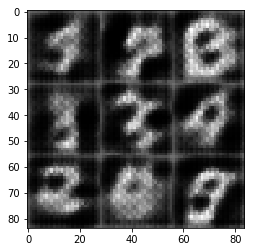

Epoch 1/2, step 110... Discriminator Loss: 1.1301... Generator Loss: 0.7880
Epoch 1/2, step 120... Discriminator Loss: 1.3597... Generator Loss: 0.6302
Epoch 1/2, step 130... Discriminator Loss: 1.3993... Generator Loss: 0.6116
Epoch 1/2, step 140... Discriminator Loss: 1.2073... Generator Loss: 1.0354
Epoch 1/2, step 150... Discriminator Loss: 1.3108... Generator Loss: 1.4461
Epoch 1/2, step 160... Discriminator Loss: 1.2614... Generator Loss: 0.9827
Epoch 1/2, step 170... Discriminator Loss: 1.3201... Generator Loss: 1.0552
Epoch 1/2, step 180... Discriminator Loss: 1.3285... Generator Loss: 0.6904
Epoch 1/2, step 190... Discriminator Loss: 1.2038... Generator Loss: 0.8730
Epoch 1/2, step 200... Discriminator Loss: 1.3982... Generator Loss: 0.5774


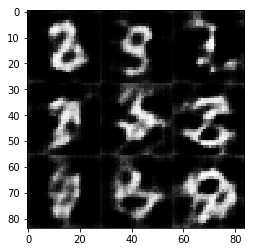

Epoch 1/2, step 210... Discriminator Loss: 1.1174... Generator Loss: 1.1290
Epoch 1/2, step 220... Discriminator Loss: 1.3659... Generator Loss: 1.4578
Epoch 1/2, step 230... Discriminator Loss: 1.2341... Generator Loss: 1.2940
Epoch 1/2, step 240... Discriminator Loss: 1.2919... Generator Loss: 1.1439
Epoch 1/2, step 250... Discriminator Loss: 1.2687... Generator Loss: 1.2285
Epoch 1/2, step 260... Discriminator Loss: 1.2669... Generator Loss: 1.0499
Epoch 1/2, step 270... Discriminator Loss: 1.2078... Generator Loss: 0.9770
Epoch 1/2, step 280... Discriminator Loss: 1.4531... Generator Loss: 1.6222
Epoch 1/2, step 290... Discriminator Loss: 1.2872... Generator Loss: 0.9495
Epoch 1/2, step 300... Discriminator Loss: 1.2462... Generator Loss: 0.9551


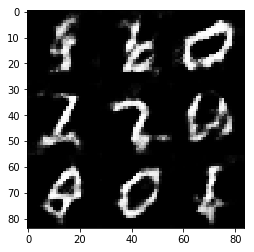

Epoch 1/2, step 310... Discriminator Loss: 1.1740... Generator Loss: 1.0648
Epoch 1/2, step 320... Discriminator Loss: 1.1777... Generator Loss: 0.8019
Epoch 1/2, step 330... Discriminator Loss: 1.2424... Generator Loss: 0.7233
Epoch 1/2, step 340... Discriminator Loss: 1.1849... Generator Loss: 1.1066
Epoch 1/2, step 350... Discriminator Loss: 1.5630... Generator Loss: 1.6321
Epoch 1/2, step 360... Discriminator Loss: 1.2110... Generator Loss: 1.0745
Epoch 1/2, step 370... Discriminator Loss: 1.3827... Generator Loss: 1.2891
Epoch 1/2, step 380... Discriminator Loss: 1.4051... Generator Loss: 0.5742
Epoch 1/2, step 390... Discriminator Loss: 1.2574... Generator Loss: 0.7832
Epoch 1/2, step 400... Discriminator Loss: 1.2111... Generator Loss: 0.8881


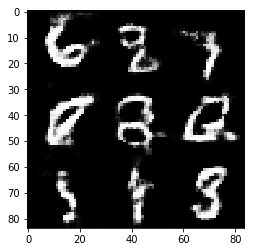

Epoch 1/2, step 410... Discriminator Loss: 1.5491... Generator Loss: 1.5100
Epoch 1/2, step 420... Discriminator Loss: 1.2392... Generator Loss: 0.8132
Epoch 1/2, step 430... Discriminator Loss: 1.2008... Generator Loss: 0.8183
Epoch 1/2, step 440... Discriminator Loss: 1.2991... Generator Loss: 0.6821
Epoch 1/2, step 450... Discriminator Loss: 1.2228... Generator Loss: 1.1913
Epoch 1/2, step 460... Discriminator Loss: 1.2055... Generator Loss: 1.0105
Epoch 2/2, step 470... Discriminator Loss: 1.2940... Generator Loss: 1.2087
Epoch 2/2, step 480... Discriminator Loss: 1.2536... Generator Loss: 1.2633
Epoch 2/2, step 490... Discriminator Loss: 1.2430... Generator Loss: 0.8303
Epoch 2/2, step 500... Discriminator Loss: 1.4035... Generator Loss: 0.5995


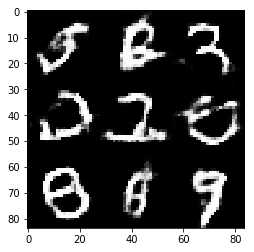

Epoch 2/2, step 510... Discriminator Loss: 1.2139... Generator Loss: 0.7581
Epoch 2/2, step 520... Discriminator Loss: 1.3911... Generator Loss: 0.5511
Epoch 2/2, step 530... Discriminator Loss: 1.2466... Generator Loss: 0.9113
Epoch 2/2, step 540... Discriminator Loss: 1.5727... Generator Loss: 1.6327
Epoch 2/2, step 550... Discriminator Loss: 1.1940... Generator Loss: 0.9465
Epoch 2/2, step 560... Discriminator Loss: 1.3068... Generator Loss: 1.4409
Epoch 2/2, step 570... Discriminator Loss: 1.2109... Generator Loss: 1.1027
Epoch 2/2, step 580... Discriminator Loss: 1.2334... Generator Loss: 1.2523
Epoch 2/2, step 590... Discriminator Loss: 1.3242... Generator Loss: 0.5987
Epoch 2/2, step 600... Discriminator Loss: 1.1895... Generator Loss: 0.7303


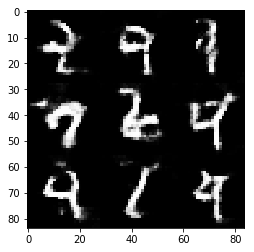

Epoch 2/2, step 610... Discriminator Loss: 1.4878... Generator Loss: 0.5236
Epoch 2/2, step 620... Discriminator Loss: 1.2333... Generator Loss: 0.7467
Epoch 2/2, step 630... Discriminator Loss: 1.1692... Generator Loss: 1.0884
Epoch 2/2, step 640... Discriminator Loss: 1.2154... Generator Loss: 1.0938
Epoch 2/2, step 650... Discriminator Loss: 1.1599... Generator Loss: 1.0246
Epoch 2/2, step 660... Discriminator Loss: 1.2620... Generator Loss: 0.6519
Epoch 2/2, step 670... Discriminator Loss: 1.1654... Generator Loss: 0.8459
Epoch 2/2, step 680... Discriminator Loss: 1.2993... Generator Loss: 1.3144
Epoch 2/2, step 690... Discriminator Loss: 1.0798... Generator Loss: 0.8504
Epoch 2/2, step 700... Discriminator Loss: 1.1689... Generator Loss: 1.2468


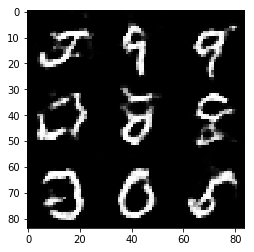

Epoch 2/2, step 710... Discriminator Loss: 1.1338... Generator Loss: 0.8165
Epoch 2/2, step 720... Discriminator Loss: 1.1932... Generator Loss: 1.0891
Epoch 2/2, step 730... Discriminator Loss: 1.2276... Generator Loss: 1.2820
Epoch 2/2, step 740... Discriminator Loss: 1.1152... Generator Loss: 1.0492
Epoch 2/2, step 750... Discriminator Loss: 1.5643... Generator Loss: 1.6861
Epoch 2/2, step 760... Discriminator Loss: 1.1894... Generator Loss: 0.8532
Epoch 2/2, step 770... Discriminator Loss: 1.1038... Generator Loss: 0.9161
Epoch 2/2, step 780... Discriminator Loss: 1.1624... Generator Loss: 0.8832
Epoch 2/2, step 790... Discriminator Loss: 1.1942... Generator Loss: 0.7758
Epoch 2/2, step 800... Discriminator Loss: 1.0581... Generator Loss: 1.0094


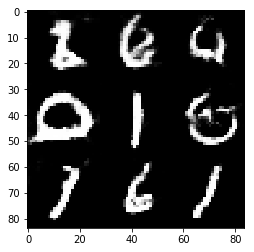

Epoch 2/2, step 810... Discriminator Loss: 1.7011... Generator Loss: 2.2163
Epoch 2/2, step 820... Discriminator Loss: 1.1254... Generator Loss: 0.8722
Epoch 2/2, step 830... Discriminator Loss: 1.2435... Generator Loss: 0.6947
Epoch 2/2, step 840... Discriminator Loss: 1.1708... Generator Loss: 0.8537
Epoch 2/2, step 850... Discriminator Loss: 2.1457... Generator Loss: 2.2613
Epoch 2/2, step 860... Discriminator Loss: 1.1062... Generator Loss: 0.9754
Epoch 2/2, step 870... Discriminator Loss: 1.1418... Generator Loss: 0.8209
Epoch 2/2, step 880... Discriminator Loss: 1.1642... Generator Loss: 0.7747
Epoch 2/2, step 890... Discriminator Loss: 1.9418... Generator Loss: 0.4002
Epoch 2/2, step 900... Discriminator Loss: 1.1972... Generator Loss: 0.8284


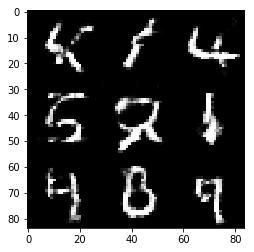

Epoch 2/2, step 910... Discriminator Loss: 1.2305... Generator Loss: 0.8297
Epoch 2/2, step 920... Discriminator Loss: 1.5411... Generator Loss: 0.5077
Epoch 2/2, step 930... Discriminator Loss: 1.1714... Generator Loss: 0.8093


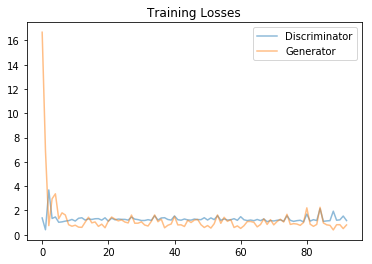

In [113]:
# Slightly modified from the values in the Radford, Metz and Chintala paper https://arxiv.org/pdf/1511.06434.pdf
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

The x axis on the graph above shows tens of steps. Though the loss of both the Generator and Discriminator are quite variable, the graph shows that the Generator loss generally settles down at a lower value than the Discriminator loss. This suggests the model is working reasonably. Some of the generated digits in the later inferences (though not all of them) do resemble handwritten digits, e.g. 4 and 9 are visible in the last set.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 1.3162... Generator Loss: 0.9139


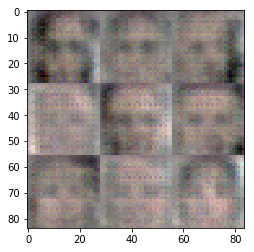

Epoch 1/5... Discriminator Loss: 1.4747... Generator Loss: 0.6940


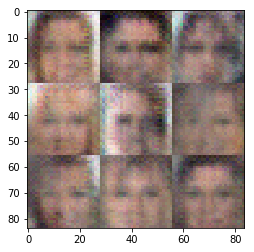

Epoch 1/5... Discriminator Loss: 1.4945... Generator Loss: 0.6938


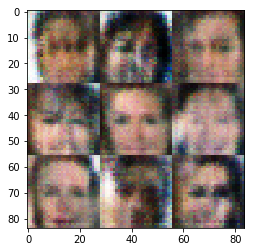

Epoch 1/5... Discriminator Loss: 1.4616... Generator Loss: 0.8711


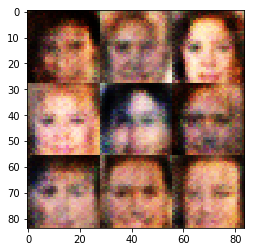

Epoch 1/5... Discriminator Loss: 1.4221... Generator Loss: 0.7578


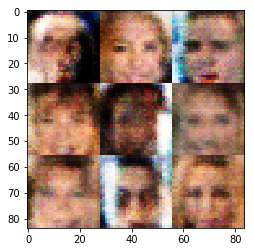

Epoch 1/5... Discriminator Loss: 1.4035... Generator Loss: 0.7720


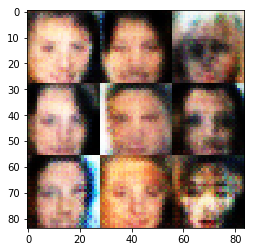

Epoch 1/5... Discriminator Loss: 1.4089... Generator Loss: 0.6736


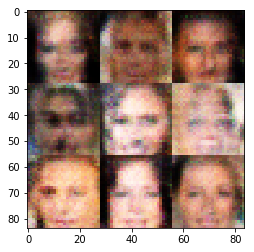

Epoch 1/5... Discriminator Loss: 1.4129... Generator Loss: 0.7490


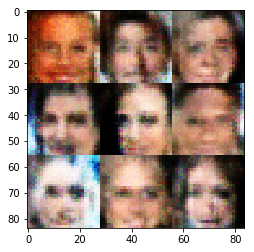

Epoch 1/5... Discriminator Loss: 1.3967... Generator Loss: 0.8151


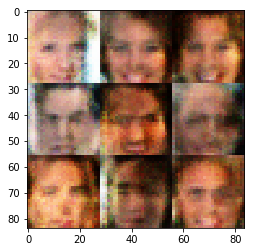

Epoch 1/5... Discriminator Loss: 1.3878... Generator Loss: 0.8708


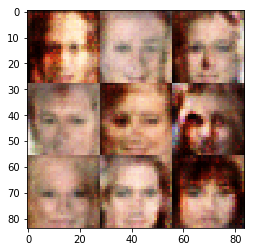

Epoch 1/5... Discriminator Loss: 1.4057... Generator Loss: 0.7635


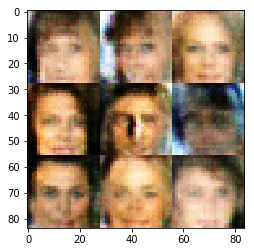

Epoch 1/5... Discriminator Loss: 1.3558... Generator Loss: 0.7308


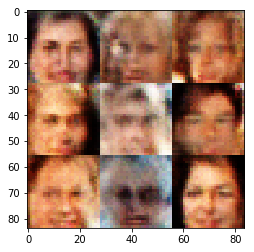

Epoch 1/5... Discriminator Loss: 1.3953... Generator Loss: 0.7351


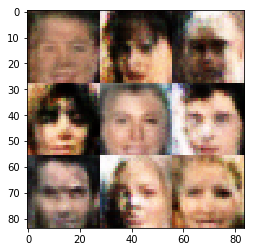

Epoch 1/5... Discriminator Loss: 1.4686... Generator Loss: 0.8685


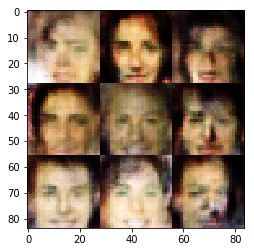

Epoch 1/5... Discriminator Loss: 1.3737... Generator Loss: 0.9109


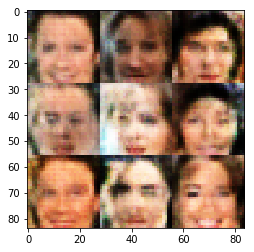

Epoch 2/5... Discriminator Loss: 1.3363... Generator Loss: 0.7383


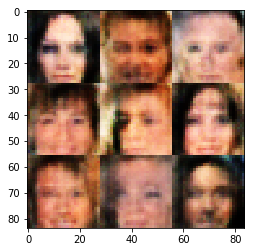

KeyboardInterrupt: 

In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.